DeepLarning Couse MSU 2016 fall: 
* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин ```jheuristic@yandex-team.ru```
* ```https://vk.com/ars.ashuha```

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.



In [1]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-04-03 01:11:08--  https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/FyvrIJar7aQdEFxD5NddFvL8tdecpqGETbHHuNKoPgLlvo2Pl4uIQgm2xlPLzzCg/file?dl=1 [following]
--2017-04-03 01:11:10--  https://dl.dropboxusercontent.com/content_link/FyvrIJar7aQdEFxD5NddFvL8tdecpqGETbHHuNKoPgLlvo2Pl4uIQgm2xlPLzzCg/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: ‘data.tar.gz’

100%[======================================>] 506,221,998  703KB/s   in 11m 46s

2017-04-03 01:22:58 (700 KB/s) - ‘data.tar.gz’ sa

### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.16 s, sys: 172 ms, total: 2.33 s
Wall time: 2.35 s


In [2]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [4]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
#word_counts = <here should be dict word:number of entrances>
from collections import Counter
word_counts = Counter()
for img_captions in captions:
    for caption in img_captions:
        word_counts.update(caption)




vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)
assert 10000 <= n_tokens <= 10500
word_to_index = {w: i for i, w in enumerate(vocab)}

In [5]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [6]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [7]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [8]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [9]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [10]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
#l_word_embeddings = <Embedding Layer>

l_word_embeddings = EmbeddingLayer(l_words,n_tokens,EMBED_SIZE)


In [11]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
#l_image_features_small = <Apply Dropout Layer to regularise your Net>
#l_image_features_small = <Apply Dense to acive LSTM_UNITS size of representation>

l_image_features_small = DropoutLayer(l_image_features,0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)



assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [12]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
#decoder = LSTMLayer(<Hmmm, what whould be here?>,
#                    num_units=LSTM_UNITS,
#                    cell_init=<Use your brain =)>,
#                    mask_input=<Mask?>,
#                    grad_clipping=<boom grads>)
        
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=5)   
                

In [13]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 200)
output shape =  (None, None, 10373)


In [14]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
#loss = <mean over non-PAD tokens>

loss = (loss*output_mask).sum() / output_mask.sum()



In [15]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
#weights = <all dnn weigts>
#updates = <your favorite optimizer>

weights = get_all_params(predicted_probabilities,trainable=True)
updates = lasagne.updates.adam(loss,weights)



In [16]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
#train_step = <>
#val_step   = <>

train_step = theano.function([image_vectors,sentences],loss,updates=updates)
val_step   = theano.function([image_vectors,sentences],loss)



# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [17]:
captions = np.array(captions)

In [18]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [19]:
generate_batch(img_codes,captions, 3)

(array([[ 1.57621801, -2.95602822, -0.73410136, ..., -0.41565394,
          0.91938019,  2.61166143],
        [ 0.2192502 ,  3.6870892 ,  1.4274857 , ...,  6.59228754,
          5.41054821,  6.97282696],
        [ 2.99770403, -1.10124493,  4.61483765, ..., -1.27920711,
         -2.84464216, -1.19510591]], dtype=float32),
 array([[ 8481,  3323,  5991,  3974,  4134,  5609,  5302,  3323,  4208,
          8134,    -1,    -1,    -1,    -1,    -1,    -1,    -1],
        [ 8481,  6766,  6252,  5726,  3980,  9933,   249,  5109,  3323,
          5155,  8717,  7449,   326,  8717,  5379,  1022,  8134],
        [ 8481,  8717,  8897,  3974,  3074,  9752,  8717,  5822,  8025,
          4810, 10014,  3221,  9879,  8134,    -1,    -1,    -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [20]:
batch_size = 50 #adjust me
n_epochs   = 100 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [21]:
%%time

from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 6.75599258222, val loss: 5.60726253648


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 5.43278071152, val loss: 5.2982656018


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 5.13468329926, val loss: 4.94971454282


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 4.93769264588, val loss: 4.80778890025


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.70680733431, val loss: 4.5530208319


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 4.55598603788, val loss: 4.38784997435


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 4.38278560808, val loss: 4.30595845492


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 4.25587740931, val loss: 4.1391886425


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 4.13935766026, val loss: 4.09116723441


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.05942650605, val loss: 4.12800427145


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 3.98460126253, val loss: 3.94723146844


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.87419824723, val loss: 3.87795841332


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.86006024762, val loss: 3.76832009264


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.79050749096, val loss: 3.83753731158


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.76224710168, val loss: 3.82757824697


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.701753333, val loss: 3.73274495393


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.63247980356, val loss: 3.59735303311


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.64915114951, val loss: 3.63511722055


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.61710876601, val loss: 3.56884021246


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.57804340266, val loss: 3.51769939571


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.54180959904, val loss: 3.53920752636


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 3.49273196398, val loss: 3.44270028083


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 3.44501812483, val loss: 3.45676207938


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 3.45809813201, val loss: 3.53935265846


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 3.44205048583, val loss: 3.47124380252


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 3.46067769718, val loss: 3.32572474343


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 3.37242271469, val loss: 3.42182863011


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 3.36026065464, val loss: 3.38763658937


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 3.32334465007, val loss: 3.40698075624


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 3.34488626667, val loss: 3.29974895187


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 3.33860864694, val loss: 3.36951237589


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 3.31075462325, val loss: 3.39160402794


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 3.28601636138, val loss: 3.26094069381


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 3.29238435132, val loss: 3.31222996711


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 3.25036722534, val loss: 3.26612786948


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 3.25741718071, val loss: 3.23466197467


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 3.21147886012, val loss: 3.25995829025


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 3.1894829616, val loss: 3.08888609955


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 3.21264189019, val loss: 3.27555880694


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 3.1479721292, val loss: 3.1692185334


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 3.18176991857, val loss: 3.10093424319


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 3.18407630231, val loss: 3.24013828346


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 3.13188725528, val loss: 3.18576315283


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 3.17559029299, val loss: 3.07166050647


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 3.15561962257, val loss: 3.18593168674


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 3.09628052003, val loss: 3.23417505299


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 3.1494362047, val loss: 3.06278491022


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 3.10430618993, val loss: 3.04222900785


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 3.15046578807, val loss: 3.07836631536


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 3.09722445826, val loss: 3.11360934925


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 3.12033086197, val loss: 3.02354457888


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 3.03766433628, val loss: 2.97146798377


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 3.07968161422, val loss: 3.02419325311


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 3.06183888859, val loss: 3.05880154498


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 3.05931905198, val loss: 2.98856617206


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 3.0622359018, val loss: 2.90722577444


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 3.05529159081, val loss: 3.0680192447


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 3.03476533281, val loss: 2.95965534598


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 3.03703276019, val loss: 2.93014956528


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 3.01311523601, val loss: 3.01279878333


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 3.03767864839, val loss: 3.00569874606


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 2.9955338296, val loss: 3.16440606501


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 3.0282996454, val loss: 3.00579022015


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 2.96368711731, val loss: 3.03802120474


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 3.0106267214, val loss: 2.94778680474


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 2.99319968036, val loss: 3.07304199139


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.98321820182, val loss: 3.12872455217


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 2.98266626839, val loss: 2.91549747698


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 2.97597920982, val loss: 3.01104482178


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 2.94602665086, val loss: 2.93058613443


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 2.9719212317, val loss: 2.98626903236


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 2.97097813016, val loss: 2.94381463222


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 2.95708269892, val loss: 3.00878856348


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 2.97221787871, val loss: 2.89459859337


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 2.97162054151, val loss: 2.88614327357


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 2.93825730048, val loss: 2.93990796892


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 2.92388726534, val loss: 2.98709998009


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 2.91246516207, val loss: 2.94287201414


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.88305334559, val loss: 2.95175407634


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 2.87289961503, val loss: 2.93095139944


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 2.91759063368, val loss: 2.87412819307


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 2.90899825894, val loss: 3.03001041316


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 2.90786911642, val loss: 2.91619844229


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 2.89204299231, val loss: 2.75573806698


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 2.89089972534, val loss: 2.87374093428


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 2.86031267895, val loss: 2.89427853676


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 2.90430450259, val loss: 2.87558932365


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 2.91067452981, val loss: 2.77332343328


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 2.84497840088, val loss: 2.96985033717


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 2.89077025319, val loss: 2.76473457354


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 2.90265228077, val loss: 2.86607753044


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 2.83344168699, val loss: 2.87047008938


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.85843512061, val loss: 2.86474776472


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 2.89255761776, val loss: 2.75890039056


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 2.88361977, val loss: 2.92732486732


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 2.88514770492, val loss: 2.80928355196


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 2.88007660955, val loss: 2.86125334897


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 2.84182541493, val loss: 2.87857196646


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 2.80268313051, val loss: 2.73038042878


100%|██████████| 50/50 [01:07<00:00,  1.37s/it]



Epoch: 99, train loss: 2.82665617263, val loss: 2.90320857022
Finish :)
CPU times: user 3h 42min 51s, sys: 5min 17s, total: 3h 48min 8s
Wall time: 2h 8min 41s


### apply trained model

In [22]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

/home/user/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


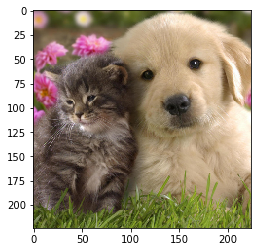

In [24]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [25]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [26]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

black stuffed animals that are sitting on the snow bench in the alleyway
a small white dog is in a chair on the tooth
a beautiful man playing with a tropical dogs
a kitten babies in his grass with a red jacket and planters for it
#UNK# and a lady wearing a hat and tie are under a yellow pad
a man and white photo of a adult and a cat in a basket of red shirt with a truck stands in the distance in front of a car
a picture of a brown bull with its head of stuff and its #UNK# window
white young white kitten lying on a brown chair
a little baby window of a chair that is wedged out of her head
dog walking across a blue shirt holding a frisbee and a girl takes on it
